Generated synthetic data: (731, 7)
Train size: 584, Test size: 146
Evaluation (train): MAE=5.36, RMSE=6.94, interval_coverage=78.77%
Evaluation (test): MAE=15.43, RMSE=19.19, interval_coverage=63.01%

Top features (by importance):
 - lag_14: importance 0.5027
 - rmean_7: importance 0.0920
 - lag_28: importance 0.0850
 - is_promo: importance 0.0632
 - lag_7: importance 0.0587
 - rstd_7: importance 0.0539
 - temp_c: importance 0.0471
 - lag_1: importance 0.0417
 - month_cos: importance 0.0257
 - dow_sin: importance 0.0155


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.w


Future forecast (first rows):
        date        pred       lower       upper  is_holiday  is_promo  \
0 2024-12-31  132.296826  117.174649  160.251042           0         0   
1 2025-01-01  128.072040  110.363718  163.011478           1         0   
2 2025-01-02  126.115739  110.363718  158.293638           0         0   
3 2025-01-03  131.854002  108.358269  165.807844           0         0   
4 2025-01-04  143.967558  105.930753  182.827921           0         0   

      temp_c  
0  28.670986  
1  28.755390  
2  28.837203  
3  28.916402  
4  28.992962  

Suggested additional data to improve model accuracy:
 - Store store-level inventory or stockouts (helps disentangle demand vs supply constraints).
 - Add POS-level promotions metadata (discount %, channel, ad spend, placement).
 - Include competitor pricing and competitor promotions.
 - More granular weather data (hourly, precipitation, humidity) and regional weather for stores.
 - Economic indicators (local unemployment, footfal

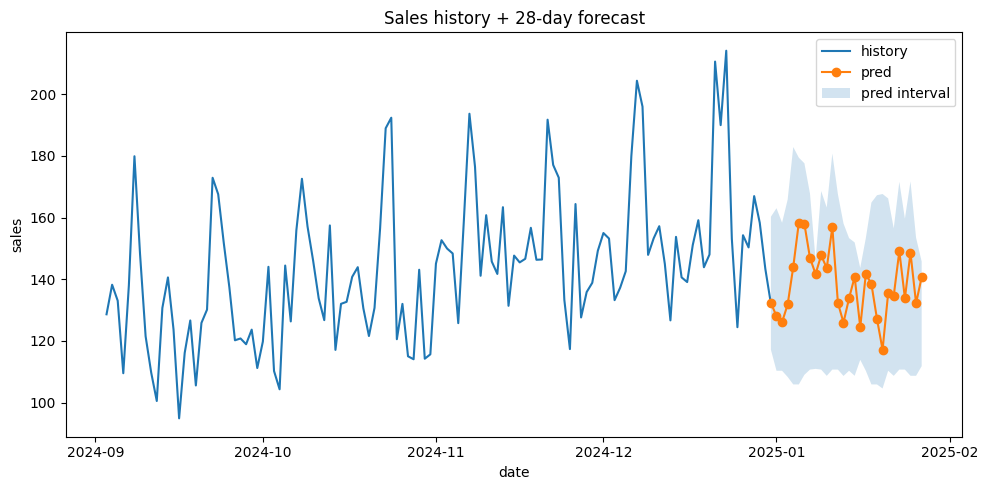

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import joblib
import os

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


def generate_synthetic_data(start_date="2023-01-01", end_date="2024-12-31"):
    """
    Generate daily sales for two years with events:
    - holidays (binary)
    - promotions (binary)
    - weather temperature (continuous)
    - day-of-week seasonality
    """
    dates = pd.date_range(start=start_date, end=end_date, freq="D")
    n = len(dates)
    df = pd.DataFrame({"date": dates})
    df["day_of_week"] = df["date"].dt.weekday  # 0=Mon
    df["month"] = df["date"].dt.month

    # Holidays: pick some fixed dates each year (New Year, mid-year, autumn)
    holidays = []
    for year in df["date"].dt.year.unique():
        holidays.append(pd.Timestamp(year=year, month=1, day=1))
        holidays.append(pd.Timestamp(year=year, month=8, day=15))
        holidays.append(pd.Timestamp(year=year, month=10, day=24))
    df["is_holiday"] = df["date"].isin(holidays).astype(int)

    # Promotions: periodic short campaigns (example)
    df["is_promo"] = 0
    promo_days = []
    for d in pd.date_range(start=start_date, end=end_date, freq="15D"):
        window = pd.date_range(d, periods=3, freq="D")
        promo_days.extend(window)
    df.loc[df["date"].isin(promo_days), "is_promo"] = 1

    # Weather (temperature): seasonal sinusoid + noise
    days = np.arange(n)
    temp = 20 + 10 * np.sin(2 * np.pi * days / 365.25) + np.random.normal(0, 2, n)
    df["temp_c"] = temp

    # Base sales (trend + weekly seasonality)
    base = 100 + 0.05 * days  # slow upward trend
    weekly = 5 * np.where(df["day_of_week"] >= 5, 1, 0)  # weekend bump
    monthly = 10 * np.where(df["month"].isin([11, 12]), 1, 0)  # holiday season spike

    holiday_effect = df["is_holiday"] * 25
    promo_effect = df["is_promo"] * 40
    temp_effect = 0.8 * (df["temp_c"] - df["temp_c"].mean())

    noise = np.random.normal(0, 12, n)

    df["sales"] = base + weekly + monthly + holiday_effect + promo_effect + temp_effect + noise
    df["sales"] = df["sales"].clip(lower=0).round(2)
    return df


def create_features(df):
    """Create lag, rolling, and event features for ML model."""
    df = df.copy()
    df = df.sort_values("date")
    # Lag features
    for lag in [1, 7, 14, 28]:
        df[f"lag_{lag}"] = df["sales"].shift(lag)
    # Rolling features (shifted to avoid leakage)
    df["rmean_7"] = df["sales"].rolling(window=7, min_periods=1).mean().shift(1)
    df["rstd_7"] = df["sales"].rolling(window=7, min_periods=1).std().shift(1).fillna(0)

    # Cyclical encoding for day-of-week and month
    df["dow_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * (df["month"] - 1) / 12)
    df["month_cos"] = np.cos(2 * np.pi * (df["month"] - 1) / 12)

    # Use bfill() instead of fillna(method="bfill")
    df = df.bfill().fillna(0)
    return df


def train_models(X_train, y_train):
    """Train a point model (LS) plus two quantile models (lower, upper)."""
    # Point forecast model
    point_model = GradientBoostingRegressor(random_state=RANDOM_SEED, n_estimators=200)
    point_model.fit(X_train, y_train)

    # Quantile models for prediction intervals
    lower_q = 0.1
    upper_q = 0.9
    q_lower = GradientBoostingRegressor(loss="quantile", alpha=lower_q, random_state=RANDOM_SEED, n_estimators=200)
    q_upper = GradientBoostingRegressor(loss="quantile", alpha=upper_q, random_state=RANDOM_SEED, n_estimators=200)
    q_lower.fit(X_train, y_train)
    q_upper.fit(X_train, y_train)

    return {
        "point": point_model,
        "q_lower": q_lower,
        "q_upper": q_upper,
    }


def evaluate_models(models, X, y, label="test"):
    preds = models["point"].predict(X)
    lower = models["q_lower"].predict(X)
    upper = models["q_upper"].predict(X)

    mae = mean_absolute_error(y, preds)
    # compute RMSE in a way that works with all scikit-learn versions
    rmse = np.sqrt(mean_squared_error(y, preds))

    coverage = np.mean((y >= lower) & (y <= upper))  # fraction of true values within interval

    print(f"Evaluation ({label}): MAE={mae:.2f}, RMSE={rmse:.2f}, interval_coverage={coverage:.2%}")
    return {"mae": mae, "rmse": rmse, "coverage": coverage, "preds": preds, "lower": lower, "upper": upper}


def feature_importances(models, feature_names, topk=10):
    """Return feature importances from the point model and optionally quantile models."""
    importances = models["point"].feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    return fi.head(topk)


def predict_future(models, last_df, feature_cols, periods=28):
    """
    Produce future predictions by iteratively generating features.
    last_df: the historical df that contains up-to-date features (sorted by date)
    feature_cols: list of feature column names used by the model
    This is a simple recursive forecasting approach.
    """
    future_rows = []
    current = last_df.copy().sort_values("date").iloc[-60:].copy()  # a window we can use for rolling features
    last_date = current["date"].max()
    for i in range(1, periods + 1):
        next_date = last_date + pd.Timedelta(days=1)
        row = {"date": next_date}
        row["day_of_week"] = next_date.weekday()
        row["month"] = next_date.month
        # event example: assume fixed holidays on certain dates
        row["is_holiday"] = 1 if (next_date.month, next_date.day) in [(1, 1), (8, 15), (10, 24)] else 0
        # promotions: simple rule - promotions on day divisible by 15 (example)
        row["is_promo"] = 1 if (next_date.day % 15 == 0) else 0
        # seasonal average temperature for the day
        seasonal_temp = 20 + 10 * np.sin(2 * np.pi * ((len(current) + i) % 365) / 365.25)
        row["temp_c"] = seasonal_temp

        # Append an empty sales row with a placeholder so we can compute lag/rolling features
        temp_df = pd.concat([current, pd.DataFrame([row])], ignore_index=True, sort=False)
        temp_df = temp_df.sort_values("date").reset_index(drop=True)

        # If sales missing in the new row, fill with last known sales value (placeholder)
        if "sales" not in temp_df.columns:
            temp_df["sales"] = np.nan
        if temp_df["sales"].isnull().all():
            # if all sales are NaN (unlikely with historical), set to a reasonable constant
            temp_df["sales"] = temp_df["sales"].fillna(0)

        # forward-fill historical sales to make lag/rolling calculations possible
        temp_df["sales"] = temp_df["sales"].ffill().bfill()

        # create features
        temp_df = create_features(temp_df)

        # take last row's feature vector (ensure feature_cols exist)
        last_feat = temp_df.iloc[-1][feature_cols].values.reshape(1, -1)

        # predict
        p = models["point"].predict(last_feat)[0]
        lo = models["q_lower"].predict(last_feat)[0]
        hi = models["q_upper"].predict(last_feat)[0]

        # store predicted sales into the temp_df so future lags/rollings reflect predicted value
        temp_df.at[temp_df.index[-1], "sales"] = p

        # update current for next iteration (keep window)
        current = pd.concat([current, temp_df.iloc[[-1]]], ignore_index=True, sort=False)
        current = current.iloc[-60:].reset_index(drop=True)

        future_rows.append(
            {
                "date": next_date,
                "pred": float(p),
                "lower": float(lo),
                "upper": float(hi),
                "is_holiday": int(row["is_holiday"]),
                "is_promo": int(row["is_promo"]),
                "temp_c": float(row["temp_c"]),
            }
        )
        last_date = next_date

    return pd.DataFrame(future_rows)


def explain_factors(models, X_sample, feature_names, topk=10):
    """
    Use the model's built-in importances as primary signal.
    """
    fi = feature_importances(models, feature_names, topk=topk)
    print("\nTop features (by importance):")
    for name, val in fi.items():
        print(f" - {name}: importance {val:.4f}")
    return fi


def suggestions_for_better_accuracy():
    """
    Returns human-readable suggestions for additional data that typically improve forecasting.
    """
    suggestions = [
        "Store store-level inventory or stockouts (helps disentangle demand vs supply constraints).",
        "Add POS-level promotions metadata (discount %, channel, ad spend, placement).",
        "Include competitor pricing and competitor promotions.",
        "More granular weather data (hourly, precipitation, humidity) and regional weather for stores.",
        "Economic indicators (local unemployment, footfall sensors, mobility indices).",
        "Calendar flags: school holidays, local events, one-off events (sports, concerts).",
        "Customer segmentation / loyalty program signals (repeat customers vs new ones).",
        "Online ad spend / impressions / clicks aligned to date windows.",
    ]
    print("\nSuggested additional data to improve model accuracy:")
    for s in suggestions:
        print(" -", s)
    return suggestions


if __name__ == "__main__":
    # 1) Generate or load data
    df = generate_synthetic_data()
    print("Generated synthetic data:", df.shape)
    os.makedirs("output", exist_ok=True)
    df.to_csv("output/synthetic_sales.csv", index=False)

    # 2) Create features
    df_feat = create_features(df)
    # We'll predict next-day sales (shift target by -1 so features at day t predict day t+1)
    df_feat = df_feat.sort_values("date").reset_index(drop=True)
    df_feat["target"] = df_feat["sales"].shift(-1)
    df_feat = df_feat.dropna().reset_index(drop=True)

    # Choose features to use
    feature_cols = [
        "lag_1", "lag_7", "lag_14", "lag_28",
        "rmean_7", "rstd_7",
        "is_holiday", "is_promo", "temp_c",
        "dow_sin", "dow_cos", "month_sin", "month_cos"
    ]

    # Ensure features exist in df_feat (they should)
    X = df_feat[feature_cols]
    y = df_feat["target"]

    # Train-test split preserving time order: earlier 80% train, last 20% test
    split = int(len(df_feat) * 0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

    # 3) Train models
    models = train_models(X_train, y_train)

    # 4) Evaluate
    train_eval = evaluate_models(models, X_train, y_train, label="train")
    test_eval = evaluate_models(models, X_test, y_test, label="test")

    # 5) Feature importance
    fi = explain_factors(models, X_test, feature_cols, topk=10)

    # 6) Predict future 28 days
    # pass feature_cols explicitly
    future = predict_future(models, df_feat, feature_cols=feature_cols, periods=28)
    print("\nFuture forecast (first rows):")
    print(future.head())

    # Save model and outputs
    joblib.dump(models["point"], "output/point_model.joblib")
    joblib.dump(models["q_lower"], "output/q_lower_model.joblib")
    joblib.dump(models["q_upper"], "output/q_upper_model.joblib")
    future.to_csv("output/future_forecast.csv", index=False)
    fi.to_csv("output/feature_importance.csv")

    # 7) Suggestions
    suggestions = suggestions_for_better_accuracy()

    # 8) Simple plot of last historical sales + forecasts
    try:
        hist_plot = df[["date", "sales"]].set_index("date").iloc[-120:]
        plt.figure(figsize=(10, 5))
        plt.plot(hist_plot.index, hist_plot["sales"], label="history")
        plt.plot(future["date"], future["pred"], label="pred", marker="o")
        plt.fill_between(future["date"], future["lower"], future["upper"], alpha=0.2, label="pred interval")
        plt.xlabel("date")
        plt.ylabel("sales")
        plt.title("Sales history + 28-day forecast")
        plt.legend()
        plt.tight_layout()
        plt.savefig("output/forecast_plot.png", dpi=150)
        print("\nSaved plot to output/forecast_plot.png")
    except Exception as e:
        print("Plot failed:", e)

    print("\nDone. Outputs are in the ./output folder.")
